In [345]:
import pyarrow.feather as feather
import pandas as pd
import numpy as np
from scipy.io import netcdf
import matplotlib.pyplot as plt 
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import xarray as xr
import netCDF4 as nc
from netCDF4 import Dataset
import xlrd

import warnings
warnings.filterwarnings("ignore")

## divide the whole weather df int 121 dfs
## this was done once and the result is stored into csv

In [159]:
# divide the weather_df into 121 dfs only once done!!
def check_column(df):
    pt =(df["lat"],df["long"])
    if (pt[0] > rect[0]) and (pt[0] < rect[1]) and (pt[1] > rect[2]) and (pt[1] < rect[3]):
        return 1
weather_dfs =[]
for item in rects:
    # extend the rect i.e. the df is larger than the rect by 0.3 lat and long
    rect = item[0]-.3 , item[1]+.3, item[2]-.3, item[3]+.3
    weather_df["check"] = weather_df.apply(check_column, axis=1)
    widx = weather_df["long"][weather_df["check"]==1].index
    w_long = weather_df["long"].iloc[widx]
    w_lat = weather_df["lat"].iloc[widx]
    w =pd.DataFrame({"long":w_long, "lat":w_lat}).reset_index()
    weather_dfs.append(w)
    
# the divided weather_dfs with their corresponding rect
#rect_dfs = pd.DataFrame({"dfs":weather_dfs, "rect":rects})

# save the weather_dfs only once!!
for i, df in enumerate(weather_dfs):
    path ="dataset/meta_data/dfs/df{}.csv".format(i)
    df.to_csv(path, index=0)


# import weather df

In [108]:
# open a sample nc file to extract the weather stations lat/long
dir_01_2005 = "dataset/temperature/data/"+'daily_Project_TRY_air_temperature_mean__TT_200511_daymean.nc'
nc = netcdf.NetCDFFile(dir_01_2005,'r')
# long and lat where temp was measured (weather credits)
weather_long = nc.variables["lon"][:].flatten()
weather_lat = nc.variables["lat"][:].flatten()
#temp = temp_01_2005.variables["temperature"][5,:,:].flatten()
weather_df = pd.DataFrame({"long":weather_long,"lat": weather_lat})
weather_df.head()                    

,long,lat
0,5.5452,46.7198
1,5.5587,46.7204
2,5.5722,46.7209
3,5.5857,46.7215
4,5.5991,46.7221


# import the small weather dfs (divided)

In [ ]:
# import the weather dfs
w_dfs =[]
for i in range(121):
    w_dfs.append(pd.read_csv("dataset/meta_data/dfs/df{}.csv".format(i)))

# import bgr_location df

In [ ]:
bgr_location = pd.read_csv("dataset/meta_data/bgr_location.csv")
bgr_location[2995:3005]

## generate the rectangles used to divide the weather df, and will be used to match each bgr_station in one rect

In [295]:
# create rect_boundaries
n = 12
min_long = np.min(weather_df["long"])
max_long = np.max(weather_df["long"])
min_lat = np.min(weather_df["lat"])
max_lat = np.max(weather_df["lat"])
bgr_point =(47.6,5.3)
weather_dfs =[] 


weather_long_ranges = np.linspace(min_long,max_long,n)
weather_lat_ranges = np.linspace(min_lat,max_lat,n)


rects=[]
for j in range(n-1):
    for i in range(n-1):
        rects.append((weather_lat_ranges[j],weather_lat_ranges[j+1],weather_long_ranges[i],weather_long_ranges[i+1])) 

In [298]:
# find the corresponding w_df to a bgr_station
# if the bgr belongs to a rect, then corresponding df was extended (by 0.3 long and lat) more than the rect 
# to avoid the problem when a bgr_station located near the edge of the rect

def findpoint(rects, pt):
    # if bgr in a rect, get the index of the corresponding df
    rect_idx =9999
    for ind, rect in enumerate(rects):
        if (pt[0] > rect[2]) and (pt[0] < rect[3]) and (pt[1] > rect[0]) and (pt[1] < rect[1]):
            rect_idx = ind
            break
    return rect_idx


In [311]:
# compute the dist in km between any two points on the sphere surface
# depending on the long/lat (haversine formula)

def distance(w):
    # it take a weather df as arg and bgr_station global
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    lon1, lat1 = w[1], w[2]
    lon2, lat2 = bgr[0],bgr[1]
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


In [362]:
# index to run on now
id_range = 3000,... 

In [332]:
# compute the nearest dist to each bgr station

IDX =[]
for i in range(id_range[0],id_range[1]):
    #choose a bgr station
    bgr = bgr_location["bgr_long"][i],bgr_location["bgr_lat"][i]
    # find the weather_df index
    df_index = findpoint(rects, bgr)
    # compute the distances to each weather credits in the chosen df
    w_dfs[df_index]["dist"]=w_dfs[df_index].apply(distance, axis =1)
    # store the index of the weather credit that has the min dist to the chosen bgr_station 
    IDX.append(w_dfs[df_index]["index"].iloc[np.argmin(w_dfs[df_index]["dist"])])
    #print(np.min(weather_df["dist"]))
    

In [348]:
# write the extracted indices in bgr_locatio df
bgr_location["idx"].iloc[id_range[0]:id_range[1]]=IDX

Text(0.5, 1.0, 'lat')

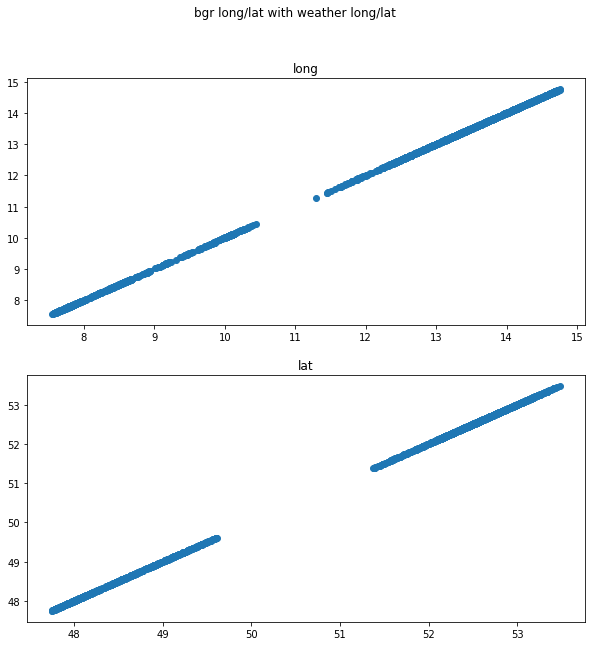

In [360]:
# plot the bgr long/lat with the extracted weather long/lat
idx = bgr_location["idx"][id_range[0]:id_range[1]]

fig, axs = plt.subplots(2, 1, figsize=(10,10))
fig.suptitle('bgr long/lat with weather long/lat ')
axs[0].scatter(weather_df["long"].iloc[idx],  bgr_location["bgr_long"][id_range[0]:id_range[1]])
axs[0].set_title('long')
axs[1].scatter(weather_df["lat"].iloc[idx],  bgr_location["bgr_lat"][id_range[0]:id_range[1]])
axs[1].set_title('lat')

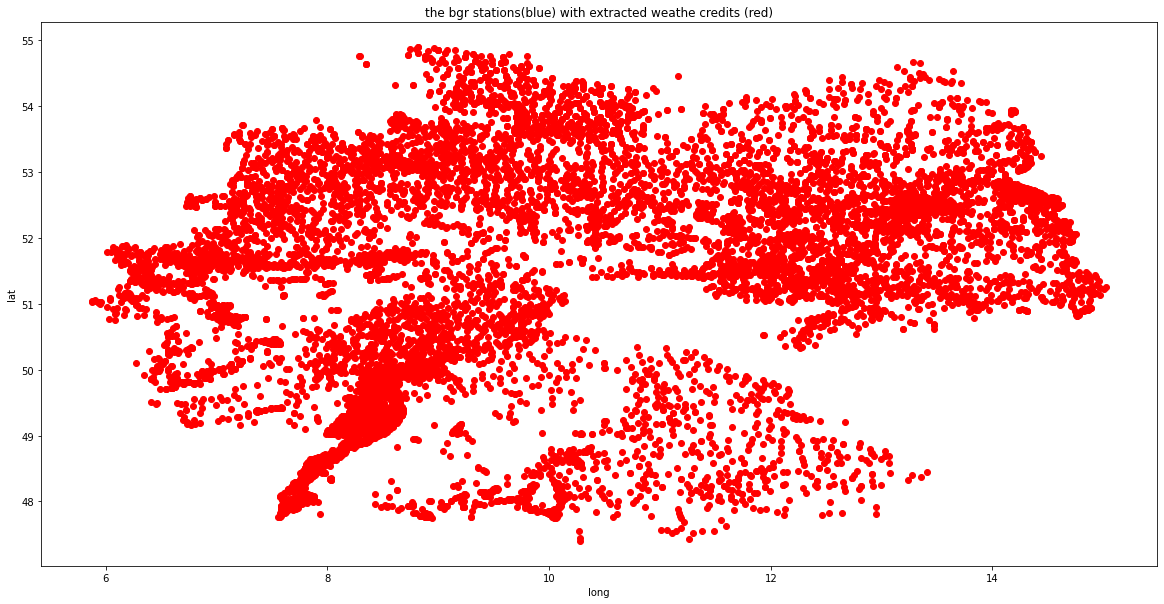

In [363]:
plt.figure(figsize=(20,10))
plt.scatter(bgr_location["bgr_long"][id_range[0]:id_range[1]], bgr_location["bgr_lat"][id_range[0]:id_range[1]],color="red")
plt.scatter(weather_df["long"].iloc[idx], weather_df["lat"].iloc[idx])
plt.xlabel('long')
plt.ylabel('lat')
plt.title("the bgr stations(blue) with extracted weathe credits (red)")
plt.show()